其他参数如何与likelihood联系起来

其他参数是通过CAMB来与likelihood联系起来吗？
通过fiducial的功率谱；

是直接把前景的功率谱（带参数的）加到fiducial的CMB功率谱上面吗？

In [ ]:
如何利用李思宇的什么数据？

# Data needed

- Theory:

> $C_{\ell}$ : theoretical power spectra from CAMB, values at each single $\ell$； (lensing BB + r + $\Lambda CDM$)

> $C_{\ell}^b$ : bandpower for each $\ell$-bin, using $W$indow function.

- Experiment(**Simulation**):

> $W$ : window function for each $\ell$ bin；

> $M$ : band power covariance matrix;

> $N_{\ell}$ : noise;

> $C_{f,l}$ : fiducial power spectra.

- Data

> $\hat {C}_{\ell} $ : observed data.

BB 95 $\times$ 95 150 $\times$ 150 95 $\times$ 150

# Class Preprocessiong

# Code

In [285]:
from ps_estimator import pstimator 

In [698]:
import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 

import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
%matplotlib inline

In [61]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

In [62]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
nbin = len(leff)
b_ind = np.arange(1,nbin+1)

In [423]:
leff

array([ 11.5,  31.5,  51.5,  71.5,  91.5, 111.5, 131.5, 151.5, 171.5,
       191.5])

## window function

 equal weight for each $\ell$ in a $\ell$-bin
 
 for bin_width = 20, weight = 1/20 = 0.05

### code

In [45]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
nb = len(leff)
for i in range(nb):

    bpwf = np.zeros(lmax-lmin+2)
    lrange = b.get_ell_list(i)
    w = b.get_weight_list(i) ## weights for each ell in i-th bin
    bpwf[lrange-lmin+1] = w
    l = np.arange(1, lmax-lmin+3)

    bpwf = np.array([l, bpwf]).T
    
    # print(np.shape(bpwf))
    # np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e'])
    # np.savetxt(data_dir + 'AliCPT_bpwf_bin%s.txt' % (i + 1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e'])
#     np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e'])

##  $C_{\ell}^b$ : fiducial bandpower for each $\ell$-bin, using Window function. or theoretical ?? 

Liu Yang's code 把由camb生成的理论功率谱当做fiducial power spectra, 如何得到 Bicep's $C_{f, \ell}$



> cl_fiducial_file = AliCPT_fiducial.dat

39x1, assuing cross power spectra for different frequencies are the same 

cl_diducial_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

### code

In [104]:
def Gencl(r = 0.05, raw_cl = True):
    '''
    Generate the theoretical power spectra using camb
    '''
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0, tau=0.078)
    pars.InitPower.set_params(As=2.19856*1e-9, ns=0.9652, r = r)
    pars.set_for_lmax(3000, lens_potential_accuracy=1)
    pars.WantTensors = True
    
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=raw_cl)
    
    totCL=powers['total'] ## TT EE BB TE
#     ell = np.arange(len(totCL.T[0]))
    return totCL.T

In [122]:
totalcl = Gencl(0.05, raw_cl=True)

In [123]:
totalcl.shape

(4, 3051)

## !!!!!!!!!!!!!!!!! ''' cl, not dl '''

In [432]:
lbin = est.lbin

In [448]:
cl_f_i = b.bin_cell(totalcl[2][0:nmtlmax+1])  ## without foreground and noise for now

cl_f = np.ones((lbin, Nf, Nf)); cl_th = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
for ell in range(lbin):
    cl_f[ell] *= cl_f_i[ell]
    cl_th[ell] *= cl_f_i[ell]

In [437]:
print(cl_f.shape)

(10, 4, 4)


### Liu Yang

In [ ]:
# soft/util/Cl_MAP_UTIL.py; From Liu Yang

def Gencl(r=0.05, lensingopt=True, opt='dl'):
    P = Params_Init()
    P.r = r
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=P.H0, ombh2=P.ombh2, omk=P.omk, tau=P.tau)
    pars.InitPower.set_params(As=P.As, ns=P.ns, r=P.r)
    pars.set_for_lmax(3000, lens_potential_accuracy=1)
    pars.max_l_tensor = 3000
    pars.WantTensors = True
    pars.NonLinear = True
    pars.DoLensing = lensingopt
    pars.Want_CMB_lensing = lensingopt
    results = camb.get_results(pars)
    #print(results.get_derived_params())
    #raw_input()
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    # the l for Cls starts from 0, for l=0,1 the Cls will 0 by default
    totCls = powers['total'].T
    l = np.arange(len(totCls[0]))
    if opt=='dl':
        ps = totCls
    elif opt=='cl':
        ps = np.zeros_like(totCls)
        ind = l!=0
        ps[:,ind] = totCls[:,ind]*2*np.pi/(l[ind]*(l[ind]+1))
    return l, ps

## Noise 

> cl_noise_file = AliCPT_noise.dat

39x7 (first line is \ell bin, what remain are cross bandpowers bwtween frequencies)

cl_noise_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

### code

In [ ]:
''' what is the unit of Noise variance map?'''

## To generate one realization of noise maps. 
SamNum = 20

In [ ]:
nvars = ['/fnx/jianyao/Likelihood_data/ABSData/plkvar_30.fits','/fnx/jianyao/Likelihood_data/ABSData/alivar_95.fits',
         '/fnx/jianyao/Likelihood_data/ABSData/alivar_150.fits','/fnx/jianyao/Likelihood_data/ABSData/plkvar_353.fits']

Nvar = np.concatenate((n1test, n2test, n3test, n4test), axis = 1)
index = np.arange(len(n3test[0]))#index[n2zeros == 0]
ali_pix = index[n3test[1] != 0]

fres = ['30','95','150','353']
for fre in range(4):
    
    var = np.sqrt(hp.read_map(nvars[fre], field = None, verbose = False))
    
    nIQU = np.zeros((3, 12*nside**2, SamNum))
    
    for i in ali_pix:
        
    #     nIQU[0][i] = 0 #np.random.normal(0, 2.05) ## ignore TT noise for now.
        nIQU[1][i] = np.random.normal(0, var[1][i], size = SamNum)
        nIQU[2][i] = np.random.normal(0, var[2][i], size = SamNum)

    np.save('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_%sGHz.npy'%(fres[fre]), (nIQU.swapaxes(1,2).swapaxes(0,1))) ## (SamNum,3, npix)

In [273]:
n30 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_30GHz.npy')

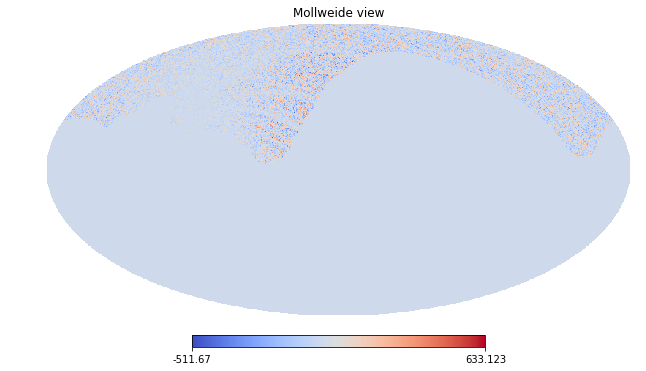

In [275]:
hp.mollview(n30[4,1], norm = 'norm', cmap='coolwarm')

### LY 

In [ ]:
# soft/util/nmt_util.py

def Noise_Cov(freq=95, opt='mask', nside=512):
	Ncov = hp.read_map('../data/I_Noise_%s_G_512.fits'%(freq))
	npix = hp.nside2npix(nside)
	sigma = np.zeros(npix)
	ind = np.isfinite(Ncov)
	sigma[ind] = Ncov[ind]
	if opt=='mask':
		mask = np.zeros(npix)
		mask[ind] = 1./(Ncov[ind]**2)
		return mask
	else:
		return sigma
    
# soft/noise_sim_v2.py

for i in range(nsim):
	print(i)
	for j in range(len(freqs)):
		nc = ncs[j]
		freq = freqs[j]
		n = np.random.normal(0, np.array([nc, nc * np.sqrt(2), nc * np.sqrt(2)]), (3, npix))
		hp.write_map('../map/noise/%dGHz/%s.fits' % (freq, i), n, overwrite=True)

## $\hat {C}_{\ell} $ : observed data.

> AliCPT_cl_hat.dat

cl_hat_file = AliCPT_cl_hat.dat 

39x7 (first line is \ell bin, what remain are cross bandpowers bwtween frequencies)

cl_hat_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

### CMB

In [209]:
cls = fits.open('/fnx/jianyao/Likelihood_data/ABSData/camb_cls.fits')

In [277]:
cmb_maps = np.zeros((SamNum, 3, 12*nside**2))
for n in range(SamNum):
    
    cmb_maps[n] = hp.synfast(Gencl(0.05, raw_cl=True), nside = nside, new = True)
    
np.save('/fnx/jianyao/Likelihood_data/cmb_maps.npy', cmb_maps)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


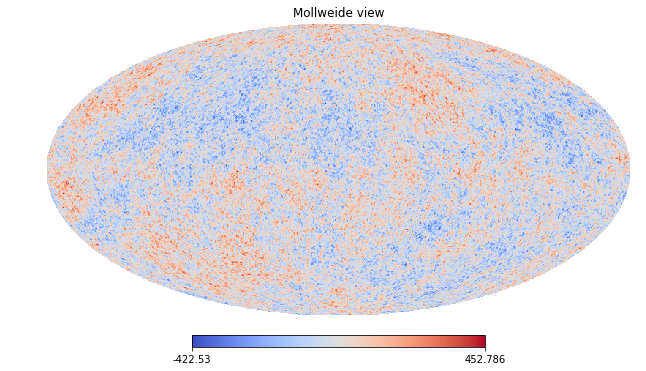

In [278]:
hp.mollview(cmb_map[0], cmap = 'coolwarm')

In [261]:
cmb_map.shape

(3, 196608)

### Mask, foreground and total map

In [387]:
ali_ma = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/ali_mask.fits', field = None)
mask = nmt.mask_apodization(ali_ma,  6, apotype='C2')
# hp.mollview(mask, title='Apodized mask')

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [288]:
## loading foreground

fore_names = ['/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_30.fits', '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_95.fits', 
              '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_150.fits', '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_353.fits' ]

fore30 = hp.read_map(fore_names[0], field = None);fore95 = hp.read_map(fore_names[1], field = None)
fore150 = hp.read_map(fore_names[2], field = None);fore353 = hp.read_map(fore_names[2], field = None)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [280]:
n30 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_30GHz.npy');
n95 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_95GHz.npy');
n150 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_150GHz.npy');
n353 = np.load('/fnx/jianyao/Likelihood_data/Noises/Noise_realizations_353GHz.npy')

cmb = np.load('/fnx/jianyao/Likelihood_data/cmb_maps.npy')

In [282]:
n30.shape

(5, 3, 196608)

In [542]:
beam_low = 19; Nf = 4

total = np.zeros((Nf, 2, 12*nside**2)); cl_hat_all = np.zeros((SamNum, 3,est.lbin, Nf, Nf))

for n in range(SamNum):
    ''' mark '''
    cmb_i = cmb[n]; 
    
    ################ without beam first
    
    total[0] = (cmb[n] + fore30 + n30[n])[1:];  ## only QU map for Jiaxin's code
    total[1] = (cmb[n] + fore95 + n95[n])[1:];
    total[2] = (cmb[n] + fore150 + n150[n])[1:]; 
    total[3] = (cmb[n] + fore353 + n353[n])[1:]; 
    
    cl_hat_all[n] = est.Cross_EB(total)## EE EB BB-mode 
    
    
    ################ considering beam
    
#     total[0] = deconv(smooth(cmb_i + fore, beam_out = 32, lmax = lmax + 100) + noise_30, beam_in = 32, beam_out = beam_low,lmax = lmax+100)
    
#     total[1] = smooth(cmb_i, beam_out = 19, lmax = lmax + 100) + fore95 + noise_95 #(, beam_in = 19, beam_out = beam_low, lmax = lmax + 100) + noise_95
    
#     total[2] = deconv(smooth(cmb_i, beam_out=11, lmax = lmax + 100) + fore150 + noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100) #+ noise_150
#     total[3] = deconv(smooth(cmb_i, beam_out=4.944, lmax = lmax + 100) + fore353 + noise_353 , beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100) #+ noise_353
    
    #################
    
## downgrade to the same resolution then calculate the bandpowers ??

In [545]:
cl_hat_all.shape

(5, 3, 10, 4, 4)

In [546]:
cl_hat = np.mean(cl_hat_all, axis = 0)

In [691]:
cl_hat.shape

(3, 10, 4, 4)

In [692]:
total.shape

(4, 2, 196608)

In [732]:
e, E = LA.eig(cl_th[5])

In [734]:
np.real(sqrtm(LA.pinv(cl_th[5])))

array([[1.47347455, 1.47347454, 1.47347455, 1.47347455],
       [1.47347455, 1.47347457, 1.47347454, 1.47347454],
       [1.47347455, 1.47347454, 1.47347455, 1.47347455],
       [1.47347455, 1.47347454, 1.47347455, 1.47347455]])

In [693]:
utils.calc_vecp(1, cl_hat[0], cl_f, cl_th)

Failed to find a square root.


/home/jianyao/Likelihood/utils.py:28: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))
/home/jianyao/Likelihood/utils.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

### Integrage BICEP's code

In [465]:
import utils
imp.reload(utils)

<module 'utils' from '/home/jianyao/Likelihood/utils.py'>

In [408]:
utils.vecp(cl_hat[0])

array([ 1.00829794e+02,  1.02737541e-01,  5.10595704e-01,  7.10845956e+02,
       -2.91668135e-01,  2.24426413e-01, -1.57183722e-01, -7.60839587e-01,
       -4.07421217e-02, -5.22125559e+00])

In [690]:
cl_hat.shape

(3, 10, 4, 4)

### calculate the bandpowers

#### Own

In [354]:
import imp 
import bandpowers
import ps_estimator

In [537]:
imp.reload(bandpowers)

<module 'bandpowers' from '/home/jianyao/Likelihood/bandpowers.py'>

In [538]:
est = bandpowers.BPE(mask_in = ali_ma, nside = 128, bin_w = 20, lmax = nmtlmax)

In [513]:
# %%timeit

bps = est.Cross_EB(total)

In [536]:
bps[1][0]

array([[ 8.98884004e+01, -1.20791754e+00, -2.67242657e+00,
        -2.87500180e+02],
       [-1.20791754e+00,  1.04614252e-01,  2.23455076e-01,
        -1.02580198e+00],
       [-2.67242657e+00,  2.23455076e-01,  4.96458654e-01,
        -2.51816356e+00],
       [-2.87500180e+02, -1.02580198e+00, -2.51816356e+00,
         2.47390858e+03]])

In [419]:
bps.shape

(2, 10, 4, 4)

## Bandpower covariance matrix

10 bins, 10-fre cross, SamNum BB

> /home/yao/Desktop/likelihood/ali_joint_analysis/CosmoMC_AliCPT/data/AliCPT_Plk/AliCPT_covmat.dat

$234 \times 234$

(39x6) * (39x6)

39-bin; bin_width = 20, nmtlmax = 800 

Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

In [550]:
cl_hat_all[n].shape

(3, 10, 4, 4)

### Get arrays for Covariance matrix

In [551]:
nf_ind = int(Nf*(Nf + 1)/2)

marray = np.zeros(((3*lbin*nf_ind), SamNum)) # mode(EE, EB, BB), l-bin, nf independent corr between frequencies 
for n in range(SamNum):
    
    for mode in range(3):
        
    
        cl_flat = np.zeros((lbin, nf_ind)) ## collect independent corr for each l-bin

        for ell in range(lbin):
            cl_flat[ell] = utils.vecp(cl_hat_all[n][mode][ell])

        marray[mode*lbin*nf_ind:(mode+1)*lbin*nf_ind,n] = cl_flat.flatten()

In [724]:
cov_mat_BB = np.corrcoef(marray[200:])
# np.cov(marray)

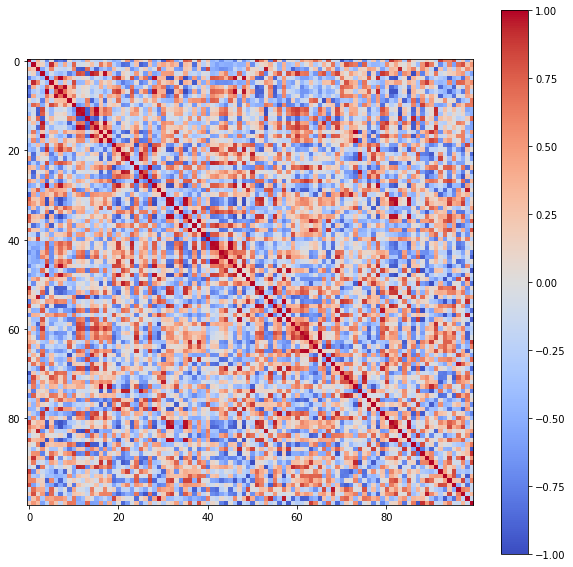

In [725]:
plt.figure(figsize = (10,10))
plt.imshow(cov_mat_BB, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()

In [722]:
cov_mat =  np.corrcoef(marray)## full covariance matrix
# 
# np.corrcoef(marray)

Text(12, 320, '$\\ell$2')

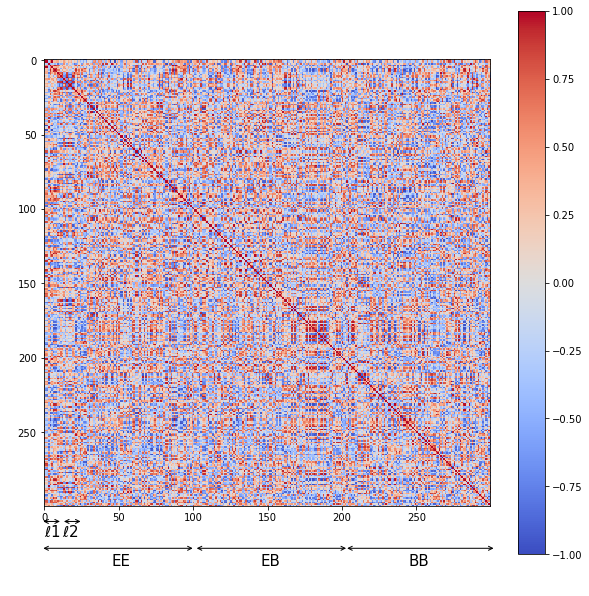

In [723]:
plt.figure(figsize = (10,10))
plt.imshow(cov_mat, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()
# plt.text(0,-5,'EE')
# plt.xticks([100], 'hh')
# plt.xlim(-10, 310)
# plt.ylim(-10, 310)

plt.annotate(s = '',xy=(0.07,0.08), xytext=(0.33,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.33,0.08), xytext=(0.59,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.585,0.08), xytext=(0.84,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.text(45, 340, 'EE', fontsize = '15')
plt.text(145, 340, 'EB', fontsize = '15')
plt.text(245, 340, 'BB', fontsize = '15')

plt.annotate(s = '',xy=(0.07,0.125), xytext=(0.105,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.105,0.125), xytext=(0.140,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')

plt.text(0, 320, '$\ell$1', fontsize = '15')
plt.text(12, 320, '$\ell$2', fontsize = '15')

In [702]:
cov_mat_BB.shape

(100, 100)

### reorganize M

In [720]:
M = np.ones((lbin, lbin, nf_ind, nf_ind))
for ell in range(lbin*nf_ind):
    i = ell//10; j = ell%10;
    for fre in range(nf_ind):
        
        M[i, j] = np.triu(cov_mat_BB[ell, nf_ind*fre:nf_ind*(fre+1)])
        
M_inv = LA.inv(M) ## only BB

### Likelihood

In [721]:
utils.evaluateLikelihood(cl_th, cl_hat[2], cl_f, M_inv)

Failed to find a square root.
Failed to find a square root.
Failed to find a square root.


/home/jianyao/Likelihood/utils.py:28: RuntimeWarning: invalid value encountered in log
  gd = np.sign(np.diag(d) - 1) * np.sqrt(2 * (np.diag(d) - np.log(np.diag(d)) - 1))
/home/jianyao/Likelihood/utils.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  vec[counter:counter+dim-iDiag] = np.diag(mat,iDiag)


LinAlgError: Eigenvalues did not converge

#### Jiaxin's implementation

In [359]:
estj = ps_estimator.pstimator(nside = 128, mask=ali_ma.reshape(1, -1), aposcale=6, psbin=20, lmax=200)

In [381]:
# %%timeit

bpsj = estj.cross_eb(np.r_[total[0], total[1]])